Setup and Imports : This block includes necessary library imports, optimizations, and configuration for the notebook.

In [16]:
# !pip install intel-extension-for-pytorch scikit-learn

In [48]:
# Imports and Setup
import timm
import torch
import os
import gc
import shutil
import time
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.cuda.amp import GradScaler, autocast
import intel_extension_for_pytorch as ipex
from torch.utils.checkpoint import checkpoint
import torch.backends.cudnn as cudnn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from neural_compressor import quantization
# from neural_compressor.config import PostTrainingQuantConfig

# Enable Intel MKL-DNN optimizations for CPU if using Intel CPU
torch.backends.mkldnn.enabled = True

# Enable mixed precision training (FP16) if using CUDA (GPU)
use_amp = torch.cuda.is_available()  # Check if CUDA is available for mixed precision
scaler = GradScaler()  # Scaler for mixed precision


/tmp/ipykernel_956/3391453884.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Scaler for mixed precision
/home/dev/conda/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Directory setup : Concatinating the data here for use below

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root="/workspace/2024/image/", transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print(dataset.class_to_idx)

benign_dir = "/workspace/2024/image/benign/"
malignant_dir = "/workspace/2024/image/malignant/"

benign_paths = [os.path.join(benign_dir, f) for f in os.listdir(benign_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
malignant_paths = [os.path.join(malignant_dir, f) for f in os.listdir(malignant_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

print(f"Benign images: {len(benign_paths)}")
print(f"Malignant images: {len(malignant_paths)}")

benign_sample = benign_paths[:len(malignant_paths)]
balanced_paths = benign_sample + malignant_paths
labels = [0] * len(benign_sample) + [1] * len(malignant_paths)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    balanced_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training samples: {len(train_paths)}, Validation samples: {len(val_paths)}")

os.makedirs("/workspace/2024/vit/dataset/train/benign", exist_ok=True)
os.makedirs("/workspace/2024/vit/dataset/train/malignant", exist_ok=True)
os.makedirs("/workspace/2024/vit/dataset/val/benign", exist_ok=True)
os.makedirs("/workspace/2024/vit/dataset/val/malignant", exist_ok=True)

for path, label in zip(train_paths, train_labels):
    target_dir = "/workspace/2024/vit/dataset/train/benign" if label == 0 else "/workspace/2024/vit/dataset/train/malignant"
    shutil.copy(path, target_dir)
for path, label in zip(val_paths, val_labels):
    target_dir = "/workspace/2024/vit/dataset/val/benign" if label == 0 else "/workspace/2024/vit/dataset/val/malignant"
    shutil.copy(path, target_dir)

{'benign': 0, 'malignant': 1}
Benign images: 401059
Malignant images: 11040
Training samples: 17664, Validation samples: 4416


Data Transformation and DataLoader Setup : This block prepares the data pipeline for training and validation, with augmentation and transformation.

In [14]:
# Data augmentation and transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Higher resolution for better performance
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Dataset and DataLoader with optimization
train_dataset = datasets.ImageFolder(root="/workspace/2024/vit/dataset/train", transform=transform)
val_dataset = datasets.ImageFolder(root="/workspace/2024/vit/dataset/val", transform=transform)

train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True, 
    prefetch_factor=2, 
    persistent_workers=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=32, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

# Print the class names and mappings
print(f"Classes: {train_dataset.classes}, Class to Index: {train_dataset.class_to_idx}")


Classes: ['benign', 'malignant'], Class to Index: {'benign': 0, 'malignant': 1}


Define the Training Function : This block defines the train_model function, which handles the training, validation, and early stopping logic.

In [15]:
# Training function with early stopping and checkpointing
def train_model(model, train_loader, val_loader, epochs=50, patience=5, checkpoint_dir="/workspace/2024/vit/checkpoints"):
    criterion = CrossEntropyLoss()
    
    best_val_loss = float('inf')  # To track the best validation loss
    epochs_without_improvement = 0  # To track patience
    best_model_wts = None  # To save the best model weights

    # Ensure checkpoint directory exists
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in range(epochs):
        start_time = time.time()  # Start time for this epoch
        
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            # Mixed precision context if using GPU
            with autocast(enabled=use_amp):
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            # Scale gradients and accumulate for larger batch sizes
            scaler.scale(loss).backward()

            # Update weights every `accumulation_steps`
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            train_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        # Compute average training loss and accuracy for the epoch
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

        # Validation phase
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)

        # Check if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            best_model_wts = model.state_dict()  # Save the best model weights
        else:
            epochs_without_improvement += 1

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch + 1}.")

        # Early stopping if no improvement for `patience` epochs
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch + 1} completed in {epoch_time:.2f} seconds.")

    # Load best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
        print("Restored the best model.")


Validation Function : This block contains the validate_model function that computes the validation loss and accuracy.

In [16]:
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return avg_val_loss, val_accuracy

Delete Cache : Clears the CPU memory by deleting unused variables and calling garbage collection.

In [17]:
def clear_cpu_memory():
    gc.collect()  # Forces Python's garbage collection to free up memory

Model Initialization and Training Loop : This block trains each model in sequence, applying Intel optimizations, training, quantization, and JIT scripting.

In [18]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model initialization for vit_tiny_patch16_224
vit_tiny = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=2)

# Use Intel optimizations for better CPU performance (IPEX)
vit_tiny, optimizer = ipex.optimize(vit_tiny, optimizer=Adam(vit_tiny.parameters(), lr=0.001), dtype=torch.float32)

# Move model to device
vit_tiny.to(device)

# Train the model
train_model(vit_tiny, train_loader, val_loader, epochs=50, patience=5)

# # Post-training Quantization using Neural Compressor
# print("Quantizing vit_tiny_patch16_224...")
# config = PostTrainingQuantConfig()
# quantized_vit_tiny = quantization.fit(vit_tiny, config=config, calib_dataloader=train_loader)

# # Save the quantized model
# torch.save(quantized_vit_tiny.state_dict(), '/workspace/2024/image/quantized_model/vit_tiny_patch16_224_quantized.pth')

# Apply JIT scripting for deployment
script_vit_tiny = torch.jit.script(vit_tiny)

# Save the scripted model
torch.jit.save(script_vit_tiny,'/workspace/2024/vit/scripted_model/vit_tiny_patch16_224_scripted.pt')

print("Training completed for vit_tiny_patch16_224.")


/tmp/ipykernel_956/545539329.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 1, Training Loss: 0.2026, Training Accuracy: 93.12%
Validation Loss: 0.1109, Validation Accuracy: 96.06%
Epoch 1 completed in 356.15 seconds.
Epoch 2, Training Loss: 0.1149, Training Accuracy: 96.27%
Validation Loss: 0.1188, Validation Accuracy: 96.29%
Epoch 2 completed in 354.67 seconds.
Epoch 3, Training Loss: 0.0919, Training Accuracy: 97.02%
Validation Loss: 0.0907, Validation Accuracy: 97.37%
Epoch 3 completed in 358.68 seconds.
Epoch 4, Training Loss: 0.0998, Training Accuracy: 96.89%
Validation Loss: 0.0868, Validation Accuracy: 97.35%
Epoch 4 completed in 366.66 seconds.
Epoch 5, Training Loss: 0.1069, Training Accuracy: 96.52%
Validation Loss: 0.1132, Validation Accuracy: 96.35%
Checkpoint saved at epoch 5.
Epoch 5 completed in 390.29 seconds.
Epoch 6, Training Loss: 0.0994, Training Accuracy: 96.93%
Validation Loss: 0.0955, Validation Accuracy: 97.40%
Epoch 6 completed in 397.12 seconds.
Epoch 7, Training Loss: 0.0860, Training Accuracy: 97.33%
Validation Loss: 0.0818, 

In [21]:
torch.save(vit_tiny.state_dict(), '/workspace/2024/vit/best_model.pth')

In [58]:
model = torch.jit.load('/workspace/2024/vit/scripted_model/vit_tiny_patch16_224_scripted.pt')

In [57]:
for i in val_loader:
    model(i[0])
    break

In [40]:
# Training data from your logs
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
training_loss = [0.2026, 0.1149, 0.0919, 0.0998, 0.1069, 0.0994, 0.0860, 0.1081, 0.1181, 0.0909, 0.0969, 0.0957]
training_accuracy = [93.12, 96.27, 97.02, 96.89, 96.52, 96.93, 97.33, 96.35, 96.08, 97.02, 96.90, 97.09]
validation_loss = [0.1109, 0.1188, 0.0907, 0.0868, 0.1132, 0.0955, 0.0818, 0.1061, 0.1113, 0.1010, 0.1184, 0.0974]
validation_accuracy = [96.06, 96.29, 97.37, 97.35, 96.35, 97.40, 97.62, 96.47, 97.15, 96.81, 96.13, 97.24]

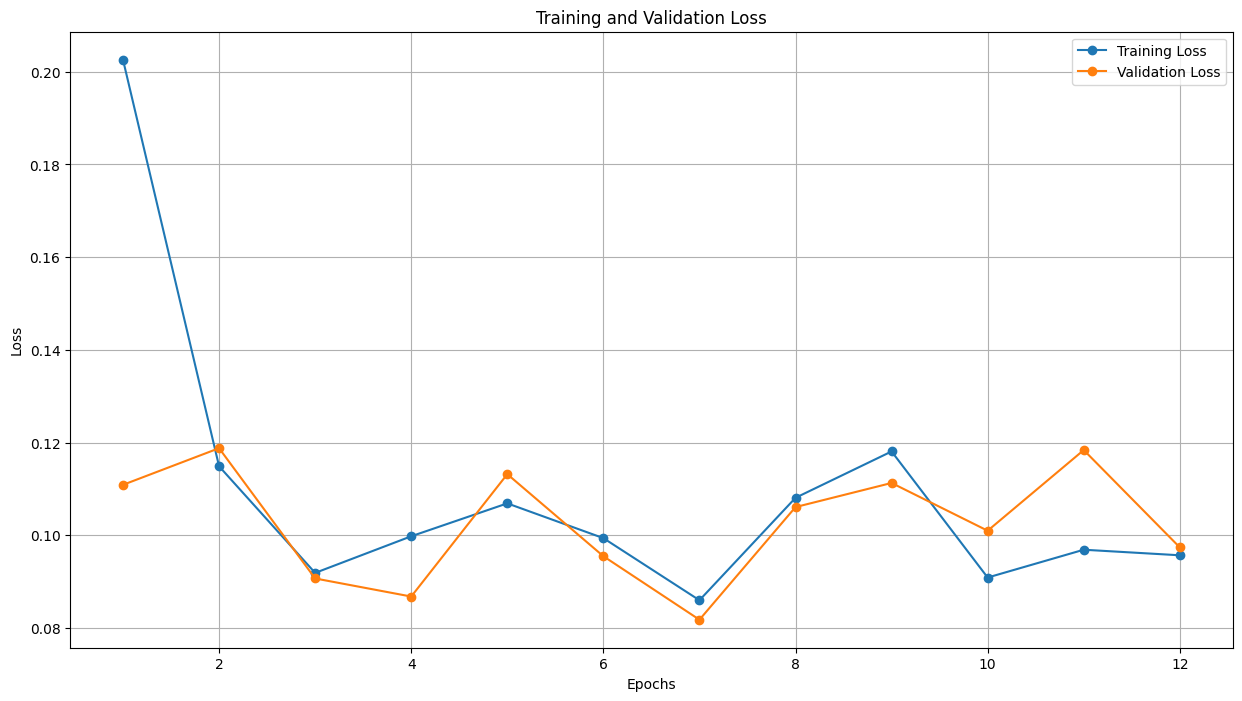

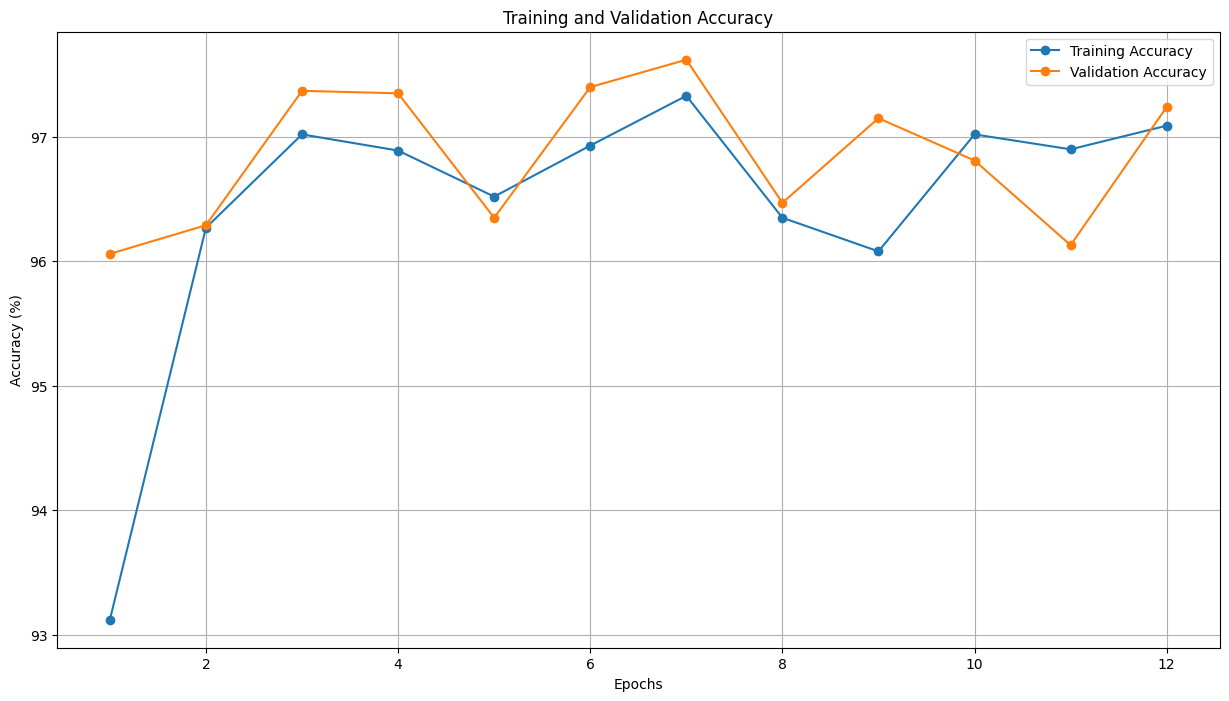

In [51]:
# Plot Training and Validation Loss
plt.figure(figsize=(15, 8))
plt.plot(epochs, training_loss, label="Training Loss", marker='o')
plt.plot(epochs, validation_loss, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.savefig("/workspace/2024/vit/Training_and_Validation_Loss.png")
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(15, 8))
plt.plot(epochs, training_accuracy, label="Training Accuracy", marker='o')
plt.plot(epochs, validation_accuracy, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()
plt.savefig("/workspace/2024/vit/Training_and_Validation_Accuracy.png")
plt.show()


/tmp/ipykernel_956/135572345.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/workspace/2024/vit/scripted_model/vit_tiny_patch16_224_scripted.pt')  #

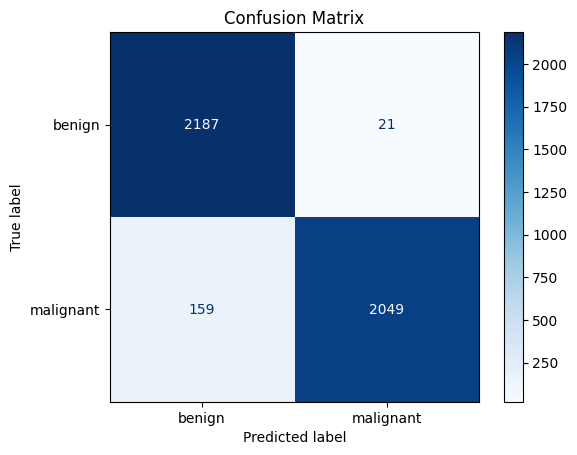

In [50]:
# Load your model from .pt file
model = torch.load('/workspace/2024/vit/scripted_model/vit_tiny_patch16_224_scripted.pt')  # Assuming your model is saved directly as .pt
model.eval()  # Set model to evaluation mode

# Prepare your validation dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size based on your model's expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Example normalization
])

validation_dataset = datasets.ImageFolder(root="/workspace/2024/vit/dataset/val", transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Run inference and collect true and predicted labels
with torch.no_grad():  # No need to compute gradients during inference
    for inputs, labels in validation_loader:
        outputs = model(inputs)  # Get model outputs
        _, predicted = torch.max(outputs, 1)  # Get predicted class (index of max output)
        
        y_true.extend(labels.numpy())  # True labels
        y_pred.extend(predicted.numpy())  # Predicted labels

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class names from the dataset
class_names = validation_dataset.classes  # Assuming this corresponds to your class labels

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Optional: If you'd like to save the confusion matrix image
disp.figure_.savefig("/workspace/2024/vit/confusion_matrix.png")
